In [ ]:
!pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
if not (os.path.isfile('Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

--2023-12-09 17:24:40--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2023-12-09 17:24:40--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  1.62MB/s    in 3.5s    

2023-12-09 17:24:44 (1.62 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-12-09 17:24:44--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

# Data Loading

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']

    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [ ]:
ytrain = to_categorical(ytrain)
ytrain.shape


(3074, 16)

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 flatten (Flatten)           (None, 18496)             0     

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

# Define the learning rate and decay
learning_rate = 0.001
decay = 1e-06

# Create an Adam optimizer with the specified learning rate and decay
adam = Adam(learning_rate=learning_rate, decay=decay)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 2.6102 - accuracy: 0.1591

13/13 [==============================] - 22s 206ms/step - loss: 2.6102 - accuracy: 0.1591
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 2.2426 - accuracy: 0.2428

13/13 [==============================] - 3s 194ms/step - loss: 2.2421 - accuracy: 0.2433
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 1.4817 - accuracy: 0.5003

13/13 [==============================] - 3s 199ms/step - loss: 1.4809 - accuracy: 0.5007
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 0.9445 - accuracy: 0.6807

13/13 [==============================] - 3s 198ms/step - loss: 0.9439 - accuracy: 0.6809
Epoch 5/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5668 - accuracy: 0.8164

13/13 [==============================] - 3s 199ms/step - loss: 0.5664 - accuracy: 0.8165
Epoch 6/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2964 - accuracy: 0.9098

13/13 [==============================] - 3s 200ms/step - loss: 0.2973 - accuracy: 0.9096
Epoch 7/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2380 - accuracy: 0.9362

13/13 [==============================] - 3s 201ms/step - loss: 0.2379 - accuracy: 0.9362
Epoch 8/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1418 - accuracy: 0.9551

13/13 [==============================] - 3s 204ms/step - loss: 0.1417 - accuracy: 0.9551
Epoch 9/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0757 - accuracy: 0.9753

13/13 [==============================] - 3s 206ms/step - loss: 0.0757 - accuracy: 0.9753
Epoch 10/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0580 - accuracy: 0.9847

13/13 [==============================] - 3s 204ms/step - loss: 0.0579 - accuracy: 0.9847
Epoch 11/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0532 - accuracy: 0.9863

13/13 [==============================] - 3s 205ms/step - loss: 0.0531 - accuracy: 0.9863
Epoch 12/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0451 - accuracy: 0.9867

13/13 [==============================] - 3s 206ms/step - loss: 0.0451 - accuracy: 0.9867
Epoch 13/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0575 - accuracy: 0.9876

13/13 [==============================] - 3s 208ms/step - loss: 0.0575 - accuracy: 0.9876
Epoch 14/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0484 - accuracy: 0.9873

13/13 [==============================] - 3s 209ms/step - loss: 0.0484 - accuracy: 0.9873
Epoch 15/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0393 - accuracy: 0.9870

13/13 [==============================] - 3s 209ms/step - loss: 0.0393 - accuracy: 0.9870
Epoch 16/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0440 - accuracy: 0.9873

13/13 [==============================] - 3s 213ms/step - loss: 0.0439 - accuracy: 0.9873
Epoch 17/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0270 - accuracy: 0.9915

13/13 [==============================] - 3s 215ms/step - loss: 0.0270 - accuracy: 0.9915
Epoch 18/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0310 - accuracy: 0.9915

13/13 [==============================] - 3s 218ms/step - loss: 0.0310 - accuracy: 0.9915
Epoch 19/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0165 - accuracy: 0.9951

13/13 [==============================] - 3s 223ms/step - loss: 0.0165 - accuracy: 0.9951
Epoch 20/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0179 - accuracy: 0.9954

13/13 [==============================] - 3s 221ms/step - loss: 0.0179 - accuracy: 0.9954
Epoch 21/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0157 - accuracy: 0.9954

13/13 [==============================] - 3s 223ms/step - loss: 0.0157 - accuracy: 0.9954
Epoch 22/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0209 - accuracy: 0.9938

13/13 [==============================] - 3s 222ms/step - loss: 0.0209 - accuracy: 0.9938
Epoch 23/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0108 - accuracy: 0.9977

13/13 [==============================] - 3s 223ms/step - loss: 0.0108 - accuracy: 0.9977
Epoch 24/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0258 - accuracy: 0.9932

13/13 [==============================] - 3s 221ms/step - loss: 0.0258 - accuracy: 0.9932
Epoch 25/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0124 - accuracy: 0.9964

13/13 [==============================] - 3s 218ms/step - loss: 0.0124 - accuracy: 0.9964
Epoch 26/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0153 - accuracy: 0.9948

13/13 [==============================] - 3s 215ms/step - loss: 0.0153 - accuracy: 0.9948
Epoch 27/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0118 - accuracy: 0.9964

13/13 [==============================] - 3s 213ms/step - loss: 0.0118 - accuracy: 0.9964
Epoch 28/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0174 - accuracy: 0.9948

13/13 [==============================] - 3s 214ms/step - loss: 0.0174 - accuracy: 0.9948
Epoch 29/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0156 - accuracy: 0.9964

13/13 [==============================] - 3s 211ms/step - loss: 0.0156 - accuracy: 0.9964
Epoch 30/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0117 - accuracy: 0.9961

13/13 [==============================] - 3s 209ms/step - loss: 0.0117 - accuracy: 0.9961
Epoch 31/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0120 - accuracy: 0.9967

13/13 [==============================] - 3s 206ms/step - loss: 0.0121 - accuracy: 0.9967
Epoch 32/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0114 - accuracy: 0.9964

13/13 [==============================] - 3s 207ms/step - loss: 0.0114 - accuracy: 0.9964
Epoch 33/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9954

13/13 [==============================] - 3s 225ms/step - loss: 0.0133 - accuracy: 0.9954
Epoch 34/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0162 - accuracy: 0.9958

13/13 [==============================] - 3s 216ms/step - loss: 0.0162 - accuracy: 0.9958
Epoch 35/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0144 - accuracy: 0.9964

13/13 [==============================] - 3s 206ms/step - loss: 0.0143 - accuracy: 0.9964
Epoch 36/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9951

13/13 [==============================] - 3s 206ms/step - loss: 0.0139 - accuracy: 0.9951
Epoch 37/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0095 - accuracy: 0.9967

13/13 [==============================] - 3s 205ms/step - loss: 0.0095 - accuracy: 0.9967
Epoch 38/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0046 - accuracy: 0.9990
Epoch 39/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0086 - accuracy: 0.9984

13/13 [==============================] - 3s 206ms/step - loss: 0.0086 - accuracy: 0.9984
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0093 - accuracy: 0.9977

13/13 [==============================] - 3s 206ms/step - loss: 0.0093 - accuracy: 0.9977
Epoch 41/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0108 - accuracy: 0.9971

13/13 [==============================] - 3s 205ms/step - loss: 0.0108 - accuracy: 0.9971
Epoch 42/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0246 - accuracy: 0.9958

13/13 [==============================] - 3s 206ms/step - loss: 0.0246 - accuracy: 0.9958
Epoch 43/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0406 - accuracy: 0.9925

13/13 [==============================] - 3s 208ms/step - loss: 0.0405 - accuracy: 0.9925
Epoch 44/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9954

13/13 [==============================] - 3s 205ms/step - loss: 0.0133 - accuracy: 0.9954
Epoch 45/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0067 - accuracy: 0.9984

13/13 [==============================] - 3s 205ms/step - loss: 0.0067 - accuracy: 0.9984
Epoch 46/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0051 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0050 - accuracy: 0.9990
Epoch 47/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984

13/13 [==============================] - 3s 207ms/step - loss: 0.0045 - accuracy: 0.9984
Epoch 48/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0043 - accuracy: 0.9980

13/13 [==============================] - 3s 208ms/step - loss: 0.0043 - accuracy: 0.9980
Epoch 49/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0049 - accuracy: 0.9980

13/13 [==============================] - 3s 209ms/step - loss: 0.0049 - accuracy: 0.9980
Epoch 50/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 0.9984

13/13 [==============================] - 3s 207ms/step - loss: 0.0040 - accuracy: 0.9984
Epoch 51/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0052 - accuracy: 0.9987

13/13 [==============================] - 3s 209ms/step - loss: 0.0052 - accuracy: 0.9987
Epoch 52/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0144 - accuracy: 0.9971

13/13 [==============================] - 3s 210ms/step - loss: 0.0144 - accuracy: 0.9971
Epoch 53/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0088 - accuracy: 0.9971

13/13 [==============================] - 3s 208ms/step - loss: 0.0088 - accuracy: 0.9971
Epoch 54/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980

13/13 [==============================] - 3s 214ms/step - loss: 0.0059 - accuracy: 0.9980
Epoch 55/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0112 - accuracy: 0.9974

13/13 [==============================] - 3s 209ms/step - loss: 0.0112 - accuracy: 0.9974
Epoch 56/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9961

13/13 [==============================] - 3s 210ms/step - loss: 0.0133 - accuracy: 0.9961
Epoch 57/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0060 - accuracy: 0.9974

13/13 [==============================] - 3s 209ms/step - loss: 0.0060 - accuracy: 0.9974
Epoch 58/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0059 - accuracy: 0.9987

13/13 [==============================] - 3s 210ms/step - loss: 0.0059 - accuracy: 0.9987
Epoch 59/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980

13/13 [==============================] - 3s 210ms/step - loss: 0.0056 - accuracy: 0.9980
Epoch 60/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 0.9977

13/13 [==============================] - 3s 208ms/step - loss: 0.0040 - accuracy: 0.9977
Epoch 61/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0144 - accuracy: 0.9987

13/13 [==============================] - 3s 207ms/step - loss: 0.0144 - accuracy: 0.9987
Epoch 62/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0167 - accuracy: 0.9971

13/13 [==============================] - 3s 207ms/step - loss: 0.0167 - accuracy: 0.9971
Epoch 63/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9990

13/13 [==============================] - 3s 208ms/step - loss: 0.0045 - accuracy: 0.9990
Epoch 64/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9980

13/13 [==============================] - 3s 213ms/step - loss: 0.0062 - accuracy: 0.9980
Epoch 65/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0064 - accuracy: 0.9984

13/13 [==============================] - 3s 211ms/step - loss: 0.0064 - accuracy: 0.9984
Epoch 66/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0098 - accuracy: 0.9977

13/13 [==============================] - 3s 207ms/step - loss: 0.0098 - accuracy: 0.9977
Epoch 67/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - accuracy: 0.9993

13/13 [==============================] - 3s 205ms/step - loss: 0.0026 - accuracy: 0.9993
Epoch 68/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0042 - accuracy: 0.9990

13/13 [==============================] - 3s 208ms/step - loss: 0.0042 - accuracy: 0.9990
Epoch 69/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0049 - accuracy: 0.9987

13/13 [==============================] - 3s 210ms/step - loss: 0.0049 - accuracy: 0.9987
Epoch 70/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 0.9987

13/13 [==============================] - 3s 205ms/step - loss: 0.0039 - accuracy: 0.9987
Epoch 71/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9980

13/13 [==============================] - 3s 207ms/step - loss: 0.0038 - accuracy: 0.9980
Epoch 72/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0048 - accuracy: 0.9990

13/13 [==============================] - 3s 206ms/step - loss: 0.0048 - accuracy: 0.9990
Epoch 73/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0052 - accuracy: 0.9987

13/13 [==============================] - 3s 206ms/step - loss: 0.0052 - accuracy: 0.9987
Epoch 74/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0119 - accuracy: 0.9980

13/13 [==============================] - 3s 208ms/step - loss: 0.0118 - accuracy: 0.9980
Epoch 75/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

13/13 [==============================] - 3s 208ms/step - loss: 0.0056 - accuracy: 0.9987
Epoch 76/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0043 - accuracy: 0.9984

13/13 [==============================] - 3s 206ms/step - loss: 0.0043 - accuracy: 0.9984
Epoch 77/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - accuracy: 0.9993

13/13 [==============================] - 3s 207ms/step - loss: 0.0026 - accuracy: 0.9993
Epoch 78/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997

13/13 [==============================] - 3s 206ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 79/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0010 - accuracy: 0.9997

13/13 [==============================] - 3s 208ms/step - loss: 0.0010 - accuracy: 0.9997
Epoch 80/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9984

13/13 [==============================] - 3s 207ms/step - loss: 0.0139 - accuracy: 0.9984
Epoch 81/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0108 - accuracy: 0.9971

13/13 [==============================] - 3s 207ms/step - loss: 0.0108 - accuracy: 0.9971
Epoch 82/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0030 - accuracy: 0.9993

13/13 [==============================] - 3s 205ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 83/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0034 - accuracy: 0.9990

13/13 [==============================] - 3s 205ms/step - loss: 0.0034 - accuracy: 0.9990
Epoch 84/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0043 - accuracy: 0.9980

13/13 [==============================] - 3s 212ms/step - loss: 0.0043 - accuracy: 0.9980
Epoch 85/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0073 - accuracy: 0.9984

13/13 [==============================] - 3s 209ms/step - loss: 0.0073 - accuracy: 0.9984
Epoch 86/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0020 - accuracy: 0.9990

13/13 [==============================] - 3s 207ms/step - loss: 0.0020 - accuracy: 0.9990
Epoch 87/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 0.9987

13/13 [==============================] - 3s 207ms/step - loss: 0.0029 - accuracy: 0.9987
Epoch 88/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0051 - accuracy: 0.9987

13/13 [==============================] - 3s 208ms/step - loss: 0.0051 - accuracy: 0.9987
Epoch 89/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0061 - accuracy: 0.9990

13/13 [==============================] - 3s 210ms/step - loss: 0.0061 - accuracy: 0.9990
Epoch 90/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 0.9990

13/13 [==============================] - 3s 208ms/step - loss: 0.0040 - accuracy: 0.9990
Epoch 91/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0135 - accuracy: 0.9974

13/13 [==============================] - 3s 207ms/step - loss: 0.0135 - accuracy: 0.9974
Epoch 92/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0083 - accuracy: 0.9990

13/13 [==============================] - 3s 208ms/step - loss: 0.0083 - accuracy: 0.9990
Epoch 93/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0065 - accuracy: 0.9984

13/13 [==============================] - 3s 206ms/step - loss: 0.0065 - accuracy: 0.9984
Epoch 94/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0051 - accuracy: 0.9990

13/13 [==============================] - 3s 211ms/step - loss: 0.0051 - accuracy: 0.9990
Epoch 95/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0101 - accuracy: 0.9977

13/13 [==============================] - 3s 207ms/step - loss: 0.0100 - accuracy: 0.9977
Epoch 96/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0037 - accuracy: 0.9984

13/13 [==============================] - 3s 205ms/step - loss: 0.0037 - accuracy: 0.9984
Epoch 97/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0041 - accuracy: 0.9993

13/13 [==============================] - 3s 206ms/step - loss: 0.0045 - accuracy: 0.9990
Epoch 98/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3352 - accuracy: 0.9450

13/13 [==============================] - 3s 205ms/step - loss: 0.3384 - accuracy: 0.9447
Epoch 99/100
12/13 [==========================>...] - ETA: 0s - loss: 0.6662 - accuracy: 0.8470

13/13 [==============================] - 3s 206ms/step - loss: 0.6657 - accuracy: 0.8471
Epoch 100/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1361 - accuracy: 0.9613

13/13 [==============================] - 3s 205ms/step - loss: 0.1360 - accuracy: 0.9613


In [ ]:
model.save("best-model.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
model.save('my_model.keras')

# Validation

In [ ]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [ ]:
ytest = to_categorical(ytest)
ytest.shape


(7175, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

225/225 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       0.99      0.99      0.99      1000
           2       1.00      0.97      0.98       581
           3       0.99      0.96      0.97       166
           4       0.99      0.99      0.99       338
           5       0.99      0.99      0.99       511
           6       1.00      0.90      0.95        20
           7       0.99      1.00      0.99       335
           8       1.00      0.64      0.78        14
           9       1.00      1.00      1.00       680
          10       0.98      0.99      0.98      1719
          11       0.97      0.93      0.95       415
          12       0.99      0.99      0.99       143
          13       0.97      1.00      0.99       886
          14       0.99      1.00      1.00       270
          15       1.00      0.92      0.96        65

    accuracy            

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*1

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 3s 12ms/step - loss: 0.0391 - accuracy: 0.9862


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



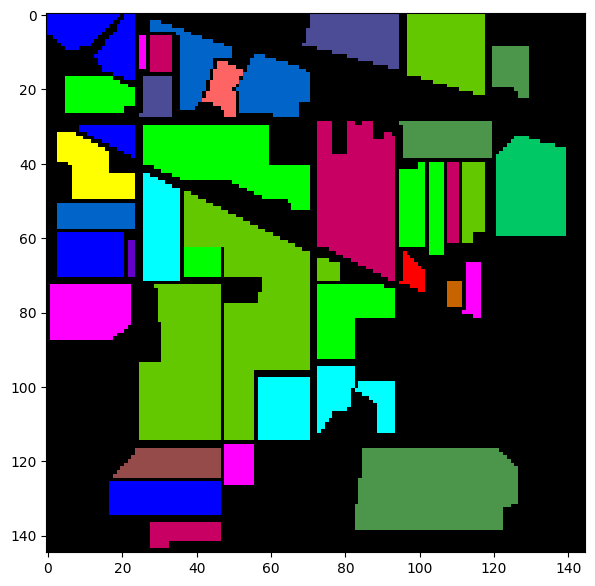

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

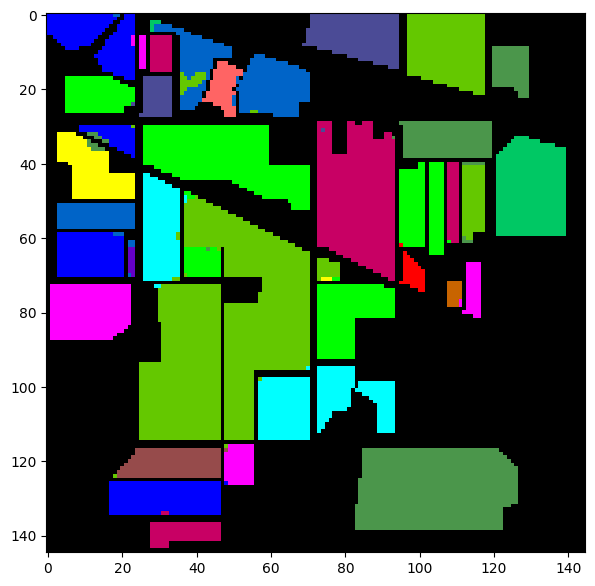

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)